In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import warnings

warnings.filterwarnings('ignore')


/Users/o.androsova/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/o.androsova/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Доступные данные:
- data/clients.csv — информация о клиентах
- data/products.csv — информация о товарах
- data/purchases.csv — история покупок клиентов до смс кампании
- data/uplift_train.csv — обучающая выборка клиентов, информация о коммуникации и конверсии
- data/uplift_test.csv — тестовые клиенты, для которых необходимо оценить uplift

In [3]:
clients = pd.read_csv('clients.csv')
products = pd.read_csv('products.csv')
purchases = pd.read_csv('purchases.csv')

uplift_train = pd.read_csv('uplift_train.csv')
uplift_test = pd.read_csv('uplift_test.csv')

In [5]:
clients.head()

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,000048b7a6,2018-12-15 13:33:11,NaN,68,F
3,000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
4,00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


In [7]:
products.head()

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
1,0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
2,0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
4,0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


In [8]:
clients['client_id'].nunique()

400162

In [9]:
products['product_id'].nunique()

43038

In [10]:
purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


In [20]:
purchases['transaction_datetime'] = pd.to_datetime(purchases['transaction_datetime'])
unique_days = purchases['transaction_datetime'].dt.date.nunique()
unique_days


118


# eda по итоговому датасету

In [19]:
final_df_raw = pd.read_csv('panel_data.csv')
final_df_raw

,Unnamed: 0,client_id,transaction_date,transaction_date.1,city_type,treatment_flg,age,female,male,purchase_sum,avg_product_quantity,total_products,ch_avg_purchase,unique_segments,unique_brands,alcohol_percentage,own_trademark_percentage
0,0,000012768d,2018-12-01,2018-12-01,1.0,0.0,45,0.0,0.0,1007.000000,1.105263,21.0,1007.0,16,14,0.000000,10.526316
1,1,000012768d,2018-12-16,2018-12-16,1.0,0.0,45,0.0,0.0,574.000000,1.272727,14.0,574.0,9,9,0.000000,9.090909
2,2,000012768d,2019-03-08,2019-03-08,1.0,0.0,45,0.0,0.0,803.000000,0.812500,13.0,803.0,13,13,0.000000,6.250000
3,3,000012768d,2019-03-14,2019-03-14,1.0,0.0,45,0.0,0.0,419.000000,1.000000,6.0,419.0,6,6,0.000000,0.000000
4,4,000036f903,2018-11-28,2018-11-28,0.0,0.0,72,1.0,0.0,241.000000,0.800000,4.0,241.0,5,5,0.000000,40.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7145657,7145657,fffff6ce77,2019-02-27,2019-02-27,1.0,1.0,42,0.0,0.0,860.331587,1.000000,5.0,424.0,5,5,20.000000,40.000000
7145658,7145658,fffff6ce77,2019-02-28,2019-02-28,1.0,1.0,42,0.0,0.0,1109.782880,1.111111,10.0,446.0,8,7,11.111111,55.555556
7145659,7145659,fffff6ce77,2019-03-05,2019-03-05,1.0,1.0,42,0.0,0.0,385.217761,1.000000,1.0,247.0,1,1,100.000000,0.000000
7145660,7145660,fffff6ce77,2019-03-06,2019-03-06,1.0,1.0,42,0.0,0.0,1117.504754,1.000000,3.0,177.0,2,2,66.666667,66.666667


In [20]:
final_df = final_df_raw.drop(columns = ['Unnamed: 0','transaction_date.1']).copy()


In [21]:
final_df

,client_id,transaction_date,city_type,treatment_flg,age,female,male,purchase_sum,avg_product_quantity,total_products,ch_avg_purchase,unique_segments,unique_brands,alcohol_percentage,own_trademark_percentage
0,000012768d,2018-12-01,1.0,0.0,45,0.0,0.0,1007.000000,1.105263,21.0,1007.0,16,14,0.000000,10.526316
1,000012768d,2018-12-16,1.0,0.0,45,0.0,0.0,574.000000,1.272727,14.0,574.0,9,9,0.000000,9.090909
2,000012768d,2019-03-08,1.0,0.0,45,0.0,0.0,803.000000,0.812500,13.0,803.0,13,13,0.000000,6.250000
3,000012768d,2019-03-14,1.0,0.0,45,0.0,0.0,419.000000,1.000000,6.0,419.0,6,6,0.000000,0.000000
4,000036f903,2018-11-28,0.0,0.0,72,1.0,0.0,241.000000,0.800000,4.0,241.0,5,5,0.000000,40.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7145657,fffff6ce77,2019-02-27,1.0,1.0,42,0.0,0.0,860.331587,1.000000,5.0,424.0,5,5,20.000000,40.000000
7145658,fffff6ce77,2019-02-28,1.0,1.0,42,0.0,0.0,1109.782880,1.111111,10.0,446.0,8,7,11.111111,55.555556
7145659,fffff6ce77,2019-03-05,1.0,1.0,42,0.0,0.0,385.217761,1.000000,1.0,247.0,1,1,100.000000,0.000000
7145660,fffff6ce77,2019-03-06,1.0,1.0,42,0.0,0.0,1117.504754,1.000000,3.0,177.0,2,2,66.666667,66.666667


In [22]:
#  Проверка пропусков
final_df.isnull().sum()

client_id                   0
transaction_date            0
city_type                   0
treatment_flg               0
age                         0
female                      0
male                        0
purchase_sum                0
avg_product_quantity        0
total_products              0
ch_avg_purchase             0
unique_segments             0
unique_brands               0
alcohol_percentage          0
own_trademark_percentage    0
dtype: int64

In [23]:
final_df.describe()

,city_type,treatment_flg,age,female,male,purchase_sum,avg_product_quantity,total_products,ch_avg_purchase,unique_segments,unique_brands,alcohol_percentage,own_trademark_percentage
count,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06
mean,4.077516e-01,4.998650e-01,4.727415e+01,3.888866e-01,1.701798e-01,5.327949e+02,1.261141e+00,7.991848e+00,4.387611e+02,5.189873e+00,5.021918e+00,2.349411e+00,1.459906e+01
std,4.914166e-01,5.000000e-01,3.949463e+01,4.874975e-01,3.757907e-01,6.101837e+02,2.164631e+00,1.211913e+01,4.835078e+02,3.944385e+00,3.967186e+00,1.053490e+01,1.952066e+01
min,0.000000e+00,0.000000e+00,-7.491000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,3.400000e+01,0.000000e+00,0.000000e+00,1.710000e+02,1.000000e+00,3.000000e+00,1.525000e+02,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,4.600000e+01,0.000000e+00,0.000000e+00,3.465100e+02,1.000000e+00,6.000000e+00,2.950000e+02,4.000000e+00,4.000000e+00,0.000000e+00,8.333333e+00
75%,1.000000e+00,1.000000e+00,6.000000e+01,1.000000e+00,0.000000e+00,6.754000e+02,1.333333e+00,1.000000e+01,5.460000e+02,7.000000e+00,7.000000e+00,0.000000e+00,2.500000e+01
max,1.000000e+00,1.000000e+00,1.901000e+03,1.000000e+00,1.000000e+00,1.099569e+05,4.614250e+03,1.845700e+04,3.514904e+04,9.500000e+01,2.720000e+02,1.000000e+02,1.000000e+02


In [24]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7145662 entries, 0 to 7145661
Data columns (total 15 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   client_id                 object 
 1   transaction_date          object 
 2   city_type                 float64
 3   treatment_flg             float64
 4   age                       int64  
 5   female                    float64
 6   male                      float64
 7   purchase_sum              float64
 8   avg_product_quantity      float64
 9   total_products            float64
 10  ch_avg_purchase           float64
 11  unique_segments           int64  
 12  unique_brands             int64  
 13  alcohol_percentage        float64
 14  own_trademark_percentage  float64
dtypes: float64(10), int64(3), object(2)
memory usage: 817.8+ MB


In [25]:
final_df.columns

Index(['client_id', 'transaction_date', 'city_type', 'treatment_flg', 'age',
       'female', 'male', 'purchase_sum', 'avg_product_quantity',
       'total_products', 'ch_avg_purchase', 'unique_segments', 'unique_brands',
       'alcohol_percentage', 'own_trademark_percentage'],
      dtype='object')

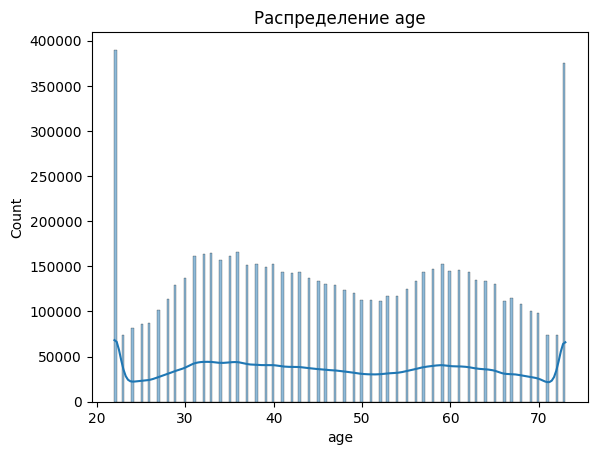

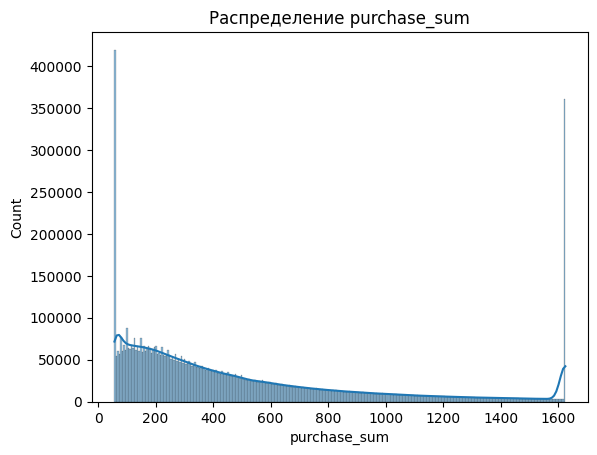

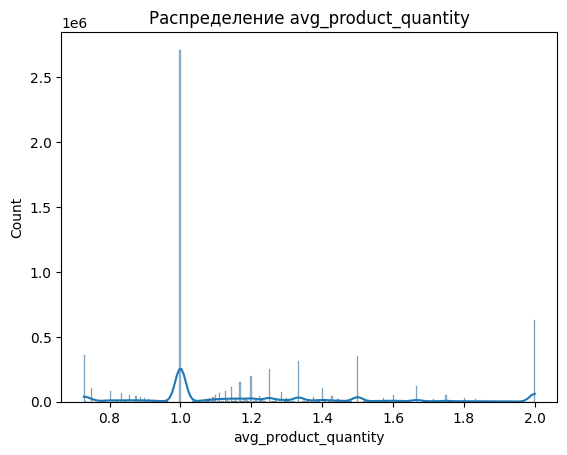

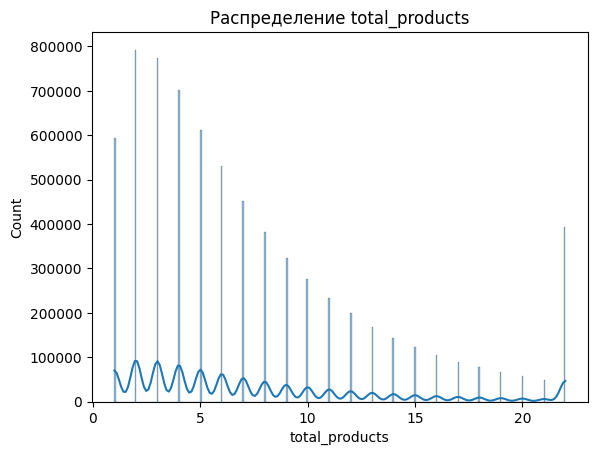

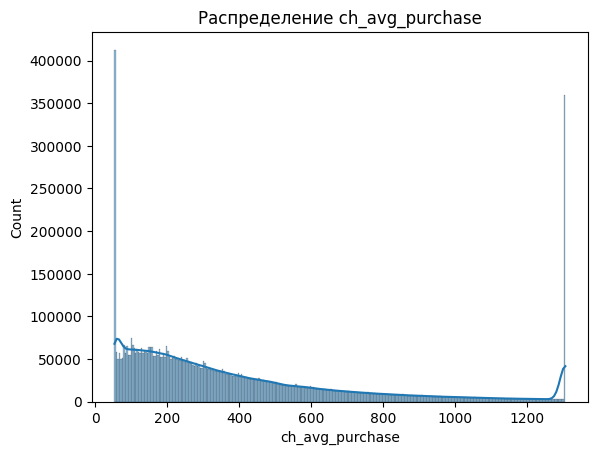

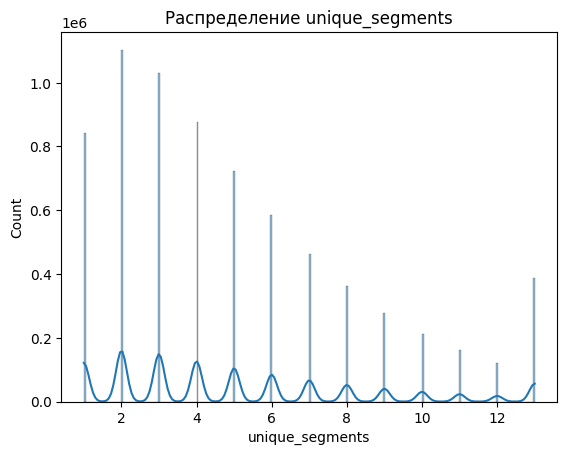

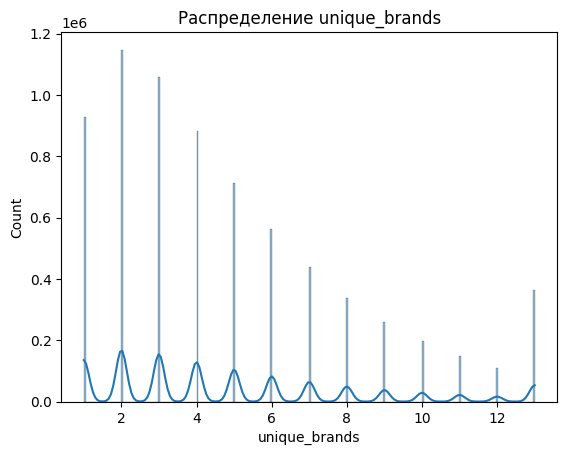

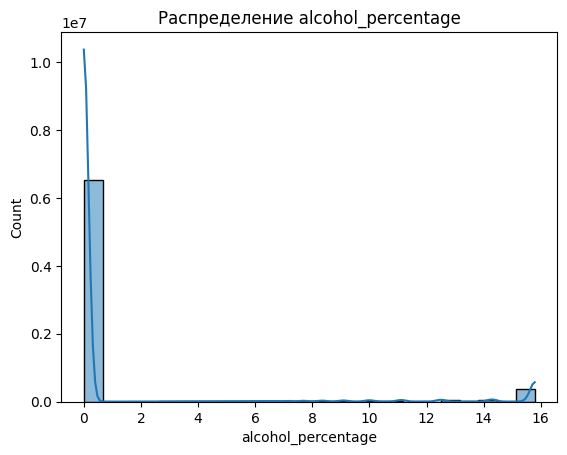

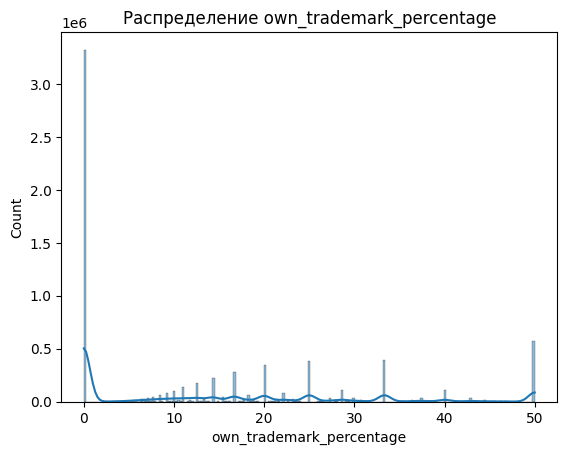

In [48]:
columns_num = [ 'age', 'purchase_sum', 'avg_product_quantity',
       'total_products', 'ch_avg_purchase', 'unique_segments', 'unique_brands',
       'alcohol_percentage', 'own_trademark_percentage']

def plot_distributions(df, cols):
    for col in cols:
        sns.histplot(df[col], kde=True)
        plt.title(f'Распределение {col}')
        plt.show()
        
plot_distributions(final_df, columns_num)

# это итоговое распределение

In [28]:
numerical_columns_2 = [ 'age', 'purchase_sum', 'avg_product_quantity',
       'total_products', 'ch_avg_purchase', 'unique_segments', 'unique_brands',
       'alcohol_percentage', 'own_trademark_percentage']


In [29]:
# Обработка выбросов с помощью винсоризации
from scipy.stats.mstats import winsorize

for col in numerical_columns_2:
    final_df[col] = winsorize(final_df[col], limits=[0.05, 0.05])

In [30]:
final_df.describe()

,city_type,treatment_flg,age,female,male,purchase_sum,avg_product_quantity,total_products,ch_avg_purchase,unique_segments,unique_brands,alcohol_percentage,own_trademark_percentage
count,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06,7.145662e+06
mean,4.077516e-01,4.998650e-01,4.706939e+01,3.888866e-01,1.701798e-01,4.936469e+02,1.203165e+00,7.437738e+00,4.053509e+02,5.011088e+00,4.845381e+00,1.153705e+00,1.350593e+01
std,4.914166e-01,5.000000e-01,1.532085e+01,4.874975e-01,3.757907e-01,4.304991e+02,3.433871e-01,5.791322e+00,3.394361e+02,3.355083e+00,3.316507e+00,3.875838e+00,1.605417e+01
min,0.000000e+00,0.000000e+00,2.200000e+01,0.000000e+00,0.000000e+00,5.700000e+01,7.272727e-01,1.000000e+00,5.399000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,3.400000e+01,0.000000e+00,0.000000e+00,1.710000e+02,1.000000e+00,3.000000e+00,1.525000e+02,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,4.600000e+01,0.000000e+00,0.000000e+00,3.465100e+02,1.000000e+00,6.000000e+00,2.950000e+02,4.000000e+00,4.000000e+00,0.000000e+00,8.333333e+00
75%,1.000000e+00,1.000000e+00,6.000000e+01,1.000000e+00,0.000000e+00,6.754000e+02,1.333333e+00,1.000000e+01,5.460000e+02,7.000000e+00,7.000000e+00,0.000000e+00,2.500000e+01
max,1.000000e+00,1.000000e+00,7.300000e+01,1.000000e+00,1.000000e+00,1.624110e+03,2.000000e+00,2.200000e+01,1.306970e+03,1.300000e+01,1.300000e+01,1.578947e+01,5.000000e+01


In [31]:
'''final_df_scaled = final_df.copy()'''

In [32]:
'''# 3. Масштабирование данных

scaler = PowerTransformer(method='yeo-johnson')
scaled_data = scaler.fit_transform(final_df[numerical_columns_2])
final_df_scaled[numerical_columns_2] = scaled_data'''

In [40]:
final_df['age'].min()

22

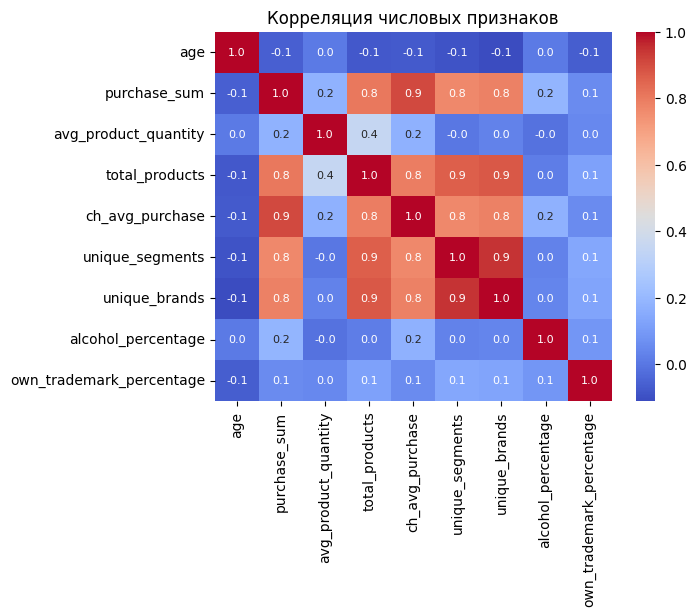

In [43]:
# 5. Анализ корреляции
correlation_matrix = final_df[numerical_columns_2].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f', annot_kws={"size": 8})
plt.title('Корреляция числовых признаков')
plt.show()



In [45]:

final_df.to_csv('final_dfdiouuy.csv', index=False)  


In [46]:
final_df

,client_id,transaction_date,city_type,treatment_flg,age,female,male,purchase_sum,avg_product_quantity,total_products,ch_avg_purchase,unique_segments,unique_brands,alcohol_percentage,own_trademark_percentage
0,000012768d,2018-12-01,1.0,0.0,45,0.0,0.0,1007.000000,1.105263,21.0,1007.0,13,13,0.000000,10.526316
1,000012768d,2018-12-16,1.0,0.0,45,0.0,0.0,574.000000,1.272727,14.0,574.0,9,9,0.000000,9.090909
2,000012768d,2019-03-08,1.0,0.0,45,0.0,0.0,803.000000,0.812500,13.0,803.0,13,13,0.000000,6.250000
3,000012768d,2019-03-14,1.0,0.0,45,0.0,0.0,419.000000,1.000000,6.0,419.0,6,6,0.000000,0.000000
4,000036f903,2018-11-28,0.0,0.0,72,1.0,0.0,241.000000,0.800000,4.0,241.0,5,5,0.000000,40.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7145657,fffff6ce77,2019-02-27,1.0,1.0,42,0.0,0.0,860.331587,1.000000,5.0,424.0,5,5,15.789474,40.000000
7145658,fffff6ce77,2019-02-28,1.0,1.0,42,0.0,0.0,1109.782880,1.111111,10.0,446.0,8,7,11.111111,50.000000
7145659,fffff6ce77,2019-03-05,1.0,1.0,42,0.0,0.0,385.217761,1.000000,1.0,247.0,1,1,15.789474,0.000000
7145660,fffff6ce77,2019-03-06,1.0,1.0,42,0.0,0.0,1117.504754,1.000000,3.0,177.0,2,2,15.789474,50.000000


In [47]:
final_df.columns

Index(['client_id', 'transaction_date', 'city_type', 'treatment_flg', 'age',
       'female', 'male', 'purchase_sum', 'avg_product_quantity',
       'total_products', 'ch_avg_purchase', 'unique_segments', 'unique_brands',
       'alcohol_percentage', 'own_trademark_percentage'],
      dtype='object')

- client_id
- transaction_date
- city_type
- treatment_flg
- age
- female
- male
- purchase_sum
- avg_product_quantity
- total_products
- ch_avg_purchase
- unique_segments
- unique_brands
- alcohol_percentage
- own_trademark_percentage